## SetUp

In [1]:
# Librerías para manejo de datos
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Librerías para preprocesamiento y modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# Librerías para métricas y evaluación
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Librerías para visualización
import matplotlib.pyplot as plt

# Librerías para redes neuronales y optimización
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Librerías para ajuste de hiperparámetros
from keras_tuner.tuners import RandomSearch
import keras_tuner as kt

# Librerías estadísticas
from scipy.stats import pointbiserialr

colors = ['darkblue', 'orange', 'green', 'red', 'purple']

In [2]:
#importacion df_final
df=pd.read_csv('../data/processed/v3_final_merge.csv')

## Data processing and exploration

In [3]:
df

,edad,sexo,nivel_educativo,fumador,actividad_fisica,vive,diabetes,hipertension,obesidad,cancer,...,region_Sur,tipo_empleo_Desempleado,tipo_empleo_Privado,tipo_empleo_Público,tipo_empleo_Temporal,continente_America,continente_Antarctica,continente_Asia,continente_Europe,continente_Oceania
0,69,0,1,1,0,1,1,1,1,0,...,0,0,0,1,0,0,0,1,0,0
1,32,1,2,0,1,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
2,89,1,0,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,78,1,1,1,0,0,1,0,1,1,...,0,0,0,0,1,0,0,1,0,0
4,38,0,3,1,1,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,21,1,2,0,2,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
49996,35,0,3,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
49997,46,1,1,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
49998,56,1,3,1,1,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


In [4]:
df.shape

(50000, 48)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   edad                     50000 non-null  int64  
 1   sexo                     50000 non-null  int64  
 2   nivel_educativo          50000 non-null  int64  
 3   fumador                  50000 non-null  int64  
 4   actividad_fisica         50000 non-null  int64  
 5   vive                     50000 non-null  int64  
 6   diabetes                 50000 non-null  int64  
 7   hipertension             50000 non-null  int64  
 8   obesidad                 50000 non-null  int64  
 9   cancer                   50000 non-null  int64  
 10  enfermedad_cardiaca      50000 non-null  int64  
 11  epoc                     50000 non-null  int64  
 12  glucosa                  50000 non-null  float64
 13  colesterol               50000 non-null  float64
 14  trigliceridos         

## Correlation

A continuación, vamos a estudiar la **correlación** de las variables con la clase objetivo que queremos predecir, es decir, si el paciente **vive o no**. Este análisis nos permitirá identificar qué variables tienen una relación más fuerte con la variable objetivo, lo que puede ser útil para seleccionar las características más relevantes para nuestra red neuronal.

In [6]:
X = df.drop(columns=['vive'])
y = df['vive']

# Calcular correlaciones
correlaciones = {}

for col in X.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        try:
            corr, _ = pointbiserialr(df[col], y)
            correlaciones[col] = corr
        except:
            correlaciones[col] = None
    else:
        correlaciones[col] = None

# Convertir a DataFrame
corr_df = pd.DataFrame.from_dict(correlaciones, orient='index', columns=['Correlación con vive'])

# Ordenar por valor absoluto
corr_df = corr_df.reindex(corr_df['Correlación con vive'].abs().sort_values(ascending=False).index)

corr_df

,Correlación con vive
cancer,-0.272906
gastos_salud,-0.262333
enfermedad_cardiaca,-0.242263
creatinina,-0.087198
epoc,-0.062929
hipertension,-0.060034
diabetes,-0.056181
leucocitos,-0.052074
fumador,-0.042654
glucosa,-0.035429


**Selección de Variables Significativas**

Para evitar introducir ruido en el modelo con datos poco significativos, inicialmente trabajaremos con las **15 variables más correlacionadas** con la variable objetivo (*vive*). Este enfoque nos ayudará a construir un modelo más eficiente y con mejor capacidad de generalización.


In [7]:
# Obtener los nombres de las 15 variables más correlacionadas
top_15_vars = corr_df.head(15).index.tolist()

# Crear nuevo DataFrame con esas variables y 'vive'
df_top15 = df[top_15_vars + ['vive']]

df_top15.head()

,cancer,gastos_salud,enfermedad_cardiaca,creatinina,epoc,hipertension,diabetes,leucocitos,fumador,glucosa,colesterol,edad,actividad_fisica,obesidad,ingresos_mensuales,vive
0,0,450,1,0.97,0,1,1,6.12,1,108.81,226.16,69,0,1,2699.72,1
1,0,150,0,0.85,0,0,0,6.97,0,74.23,148.89,32,1,0,3403.55,0
2,0,150,0,1.59,1,0,0,7.54,1,88.61,177.53,89,0,0,2422.41,1
3,1,450,1,1.26,0,0,1,8.56,1,90.92,203.97,78,0,1,1695.42,0
4,0,150,0,0.88,0,0,0,8.20,1,69.17,154.33,38,1,0,1709.51,1


In [8]:
df_top15.columns

Index(['cancer', 'gastos_salud', 'enfermedad_cardiaca', 'creatinina', 'epoc',
       'hipertension', 'diabetes', 'leucocitos', 'fumador', 'glucosa',
       'colesterol', 'edad', 'actividad_fisica', 'obesidad',
       'ingresos_mensuales', 'vive'],
      dtype='object')

## Imbalance

Antes de proceder con el modelado, es importante analizar si la clase objetivo (*vive*) está desbalanceada. Un **desbalance en las clases puede afectar negativamente el rendimiento del modelo**, especialmente en términos de su capacidad para predecir correctamente la clase minoritaria. 


In [9]:
neg, pos = np.bincount(df['vive'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total, neg, 100 * neg / total))

Examples:
    Total: 50000
    Positive: 43584 (87.17% of total)
    Negative: 6416 (12.83% of total)



Como podemos ver tenemos muy pocas muestras de aquellos pacientes que fallecen por lo que va a ser complicado estimar esta clase(0)

In [10]:
# Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)
train_df, test_df = train_test_split(df_top15, test_size=0.2, random_state=42)

# Dividir el conjunto de entrenamiento en datos para entrenamiento (80%) y validación (20%)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)



In [11]:
# Eliminamos la variable vive de los conjuntos train,test y val

X_train = train_df.drop(columns='vive')   
y_train = train_df['vive']                


X_val = val_df.drop(columns='vive')
y_val = val_df['vive']

X_test = test_df.drop(columns='vive')
y_test = test_df['vive']
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [12]:
# Verificar las formas de los conjuntos
print(f'Train features shape: {train_features.shape}')
print(f'Validation features shape: {val_features.shape}')
print(f'Test features shape: {test_features.shape}')

Train features shape: (32000, 16)
Validation features shape: (8000, 16)
Test features shape: (10000, 16)


Si la distribución de la clase 0 (*vive = 0*) es similar en cada grupo (entrenamiento, validación y prueba), podemos concluir que la división de los datos fue adecuada y que cada conjunto es representativo de la distribución original de la clase objetivo.

In [13]:
# Proporción de vive=0 en cada conjunto
train_vive_0_prop = (y_train.value_counts(normalize=True)[0] * 100).round(2)
val_vive_0_prop = (y_val.value_counts(normalize=True)[0] * 100).round(2)
test_vive_0_prop = (y_test.value_counts(normalize=True)[0] * 100).round(2)

print(f'Proporción de vive=0 en el conjunto de entrenamiento: {train_vive_0_prop}%')
print(f'Proporción de vive=0 en el conjunto de validación: {val_vive_0_prop}%')
print(f'Proporción de vive=0 en el conjunto de prueba: {test_vive_0_prop}%')

Proporción de vive=0 en el conjunto de entrenamiento: 12.69%
Proporción de vive=0 en el conjunto de validación: 12.85%
Proporción de vive=0 en el conjunto de prueba: 13.28%


## Standarize

Para evitar malas prácticas y garantizar que el modelo no aprenda información de los conjuntos de validación o prueba.
La **media y la desviación estánda**r utilizadas para estandarizar los datos se calculan exclusivamente a partir del conjunto de **entrenamienot**. Esto asegura que el modelo no tenga acceso a información de los conjuntos de validación o prueba durante el proceso de entrenamiento, lo que podría introducir sesgos y afectar negativamente su capacidad de generalización.

In [14]:
vars_a_estandarizar = [
    'gastos_salud',
    'creatinina',
    'leucocitos',
    'glucosa',
    'colesterol',
    'edad',
    'ingresos_mensuales'
]

In [15]:
scaler = StandardScaler()

X_train[vars_a_estandarizar] = scaler.fit_transform(X_train[vars_a_estandarizar])
# Aplicamos la media y desviación del train
X_val[vars_a_estandarizar] = scaler.transform(X_val[vars_a_estandarizar])
X_test[vars_a_estandarizar] = scaler.transform(X_test[vars_a_estandarizar])


## Baseline Model

**Default Bias:**

In [16]:
def make_baseline_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Sin inicializar el bias
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[BinaryAccuracy(), Precision(), Recall()]
    )
    return model

# Crear el modelo base
baseline_model = make_baseline_model()

# Entrenar el modelo base
baseline_history = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Muchas épocas para observar el comportamiento
    batch_size=2048,
    verbose=1
)

Epoch 1/100


/Users/martinagarciagonzalez/Library/Python/3.12/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.4219 - loss: 0.8278 - precision: 0.8576 - recall: 0.4066 - val_binary_accuracy: 0.4737 - val_loss: 0.7048 - val_precision: 0.8512 - val_recall: 0.4801
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.5244 - loss: 0.7348 - precision: 0.8662 - recall: 0.5402 - val_binary_accuracy: 0.6561 - val_loss: 0.6246 - val_precision: 0.8680 - val_recall: 0.7140
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6192 - loss: 0.6552 - precision: 0.8698 - recall: 0.6640 - val_binary_accuracy: 0.8301 - val_loss: 0.5626 - val_precision: 0.8764 - val_recall: 0.9373
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6972 - loss: 0.6004 - precision: 0.8742 - recall: 0.7639 - val_binary_accuracy: 0.8643 - val_loss: 0.5151 - val_precision: 0.8740 - val_recall: 0.9864
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7526 - loss: 0.5574 - precision: 0.8738 - recal

In [17]:
neg, pos = np.bincount(y_train)
initial_bias = np.log([pos / neg])

print(f"Bias inicial calculado: {initial_bias}")

Bias inicial calculado: [1.92887638]


In [18]:
# Definir el modelo con bias inicializado y una capa adicional
def make_model_with_bias(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = Sequential([
        Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[BinaryAccuracy(), Precision(), Recall()]
    )
    return model

# Crear el modelo con bias inicializado
biased_model = make_model_with_bias(output_bias=initial_bias)

# Entrenar el modelo con bias inicializado
biased_history = biased_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=2048,
    verbose=1
)

Epoch 1/100


/Users/martinagarciagonzalez/Library/Python/3.12/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.8442 - loss: 0.4483 - precision_1: 0.8732 - recall_1: 0.9611 - val_binary_accuracy: 0.8715 - val_loss: 0.4043 - val_precision_1: 0.8715 - val_recall_1: 1.0000
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8604 - loss: 0.4213 - precision_1: 0.8744 - recall_1: 0.9812 - val_binary_accuracy: 0.8715 - val_loss: 0.3904 - val_precision_1: 0.8715 - val_recall_1: 1.0000
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8697 - loss: 0.4016 - precision_1: 0.8760 - recall_1: 0.9915 - val_binary_accuracy: 0.8715 - val_loss: 0.3814 - val_precision_1: 0.8715 - val_recall_1: 1.0000
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8702 - loss: 0.3925 - precision_1: 0.8729 - recall_1: 0.9962 - val_binary_accuracy: 0.8715 - val_loss: 0.3750 - val_precision_1: 0.8715 - val_recall_1: 1.0000
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8710 - loss: 0.

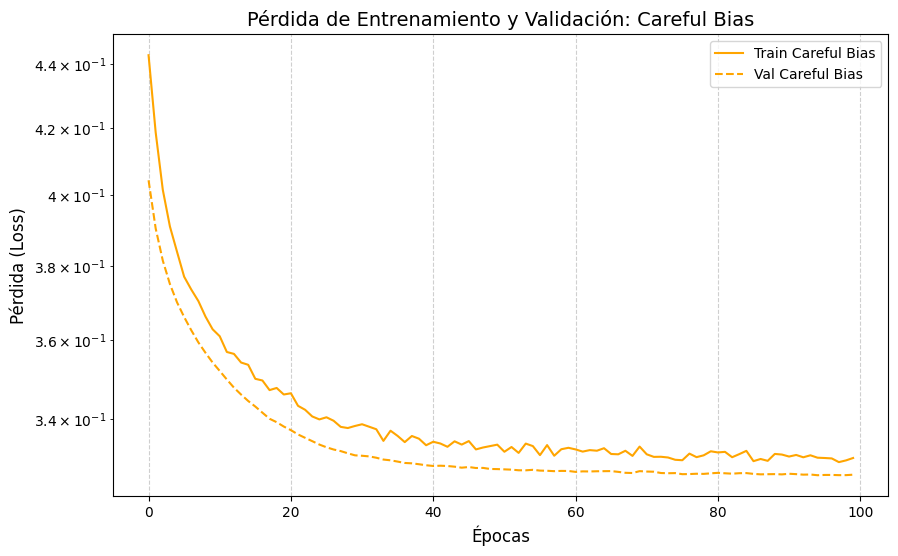

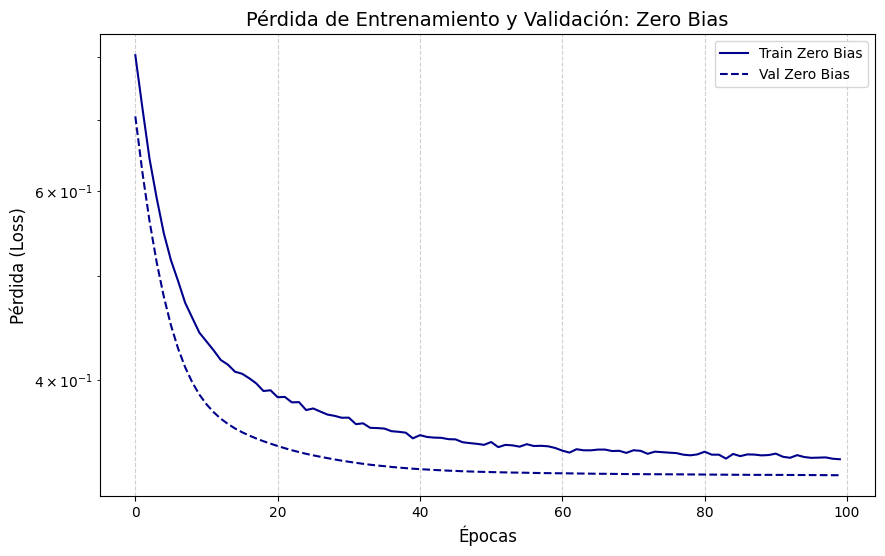

In [19]:
def plot_combined_loss(history, label, color):
    # Crear una figura para las pérdidas de entrenamiento y validación juntas
    plt.figure(figsize=(10, 6))
    
    # Graficar la pérdida de entrenamiento
    plt.semilogy(history.epoch, history.history['loss'],
                 color=color, label='Train ' + label)
    
    # Graficar la pérdida de validación
    plt.semilogy(history.epoch, history.history['val_loss'],
                 color=color, label='Val ' + label, linestyle="--")
    
    # Mejorar etiquetas y título
    plt.title(f"Pérdida de Entrenamiento y Validación: {label}", fontsize=14)
    plt.xlabel("Épocas", fontsize=12)
    plt.ylabel("Pérdida (Loss)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una cuadrícula ligera
    plt.show()

# Graficar Train y Val para Careful Bias
plot_combined_loss(biased_history, "Careful Bias", "orange")

# Graficar Train y Val para Zero Bias
plot_combined_loss(baseline_history, "Zero Bias", "darkblue")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step


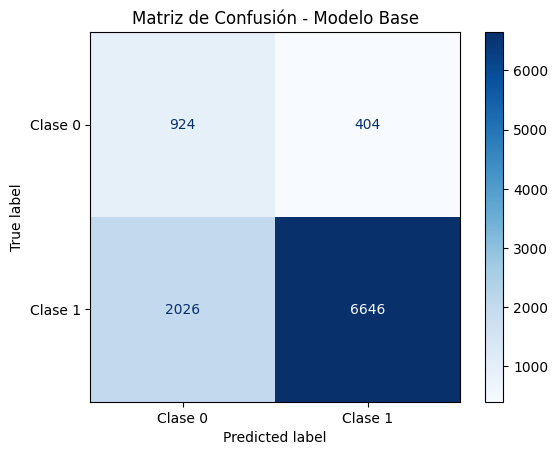

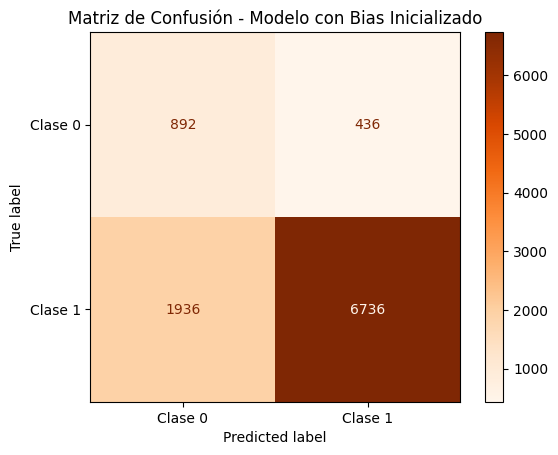

In [20]:

# Predicciones del modelo base
baseline_predictions = (baseline_model.predict(X_test) > 0.8).astype("int32")

# Predicciones del modelo con bias inicializado
biased_predictions = (biased_model.predict(X_test) > 0.8).astype("int32")

# Matriz de confusión para el modelo base
baseline_cm = confusion_matrix(y_test, baseline_predictions)
ConfusionMatrixDisplay(baseline_cm, display_labels=["Clase 0", "Clase 1"]).plot(cmap="Blues")
plt.title("Matriz de Confusión - Modelo Base")
plt.show()

# Matriz de confusión para el modelo con bias inicializado
biased_cm = confusion_matrix(y_test, biased_predictions)
ConfusionMatrixDisplay(biased_cm, display_labels=["Clase 0", "Clase 1"]).plot(cmap="Oranges")
plt.title("Matriz de Confusión - Modelo con Bias Inicializado")
plt.show()

**Ambos modelos están aprendiendo**, pero el modelo con Careful Bias muestra un mejor comportamiento en términos de pérdida y convergencia.
Esto sugiere que el sesgo inicial es una estrategia efectiva para mejorar el rendimiento en problemas con clases desbalanceadas.

In [21]:
# Classification report para el modelo base
print("Classification Report - Modelo Base")
print(classification_report(y_test, baseline_predictions, target_names=["Clase 0", "Clase 1"]))

# Classification report para el modelo con bias inicializado
print("Classification Report - Modelo con Bias Inicializado")
print(classification_report(y_test, biased_predictions, target_names=["Clase 0", "Clase 1"]))

Classification Report - Modelo Base
              precision    recall  f1-score   support

     Clase 0       0.31      0.70      0.43      1328
     Clase 1       0.94      0.77      0.85      8672

    accuracy                           0.76     10000
   macro avg       0.63      0.73      0.64     10000
weighted avg       0.86      0.76      0.79     10000

Classification Report - Modelo con Bias Inicializado
              precision    recall  f1-score   support

     Clase 0       0.32      0.67      0.43      1328
     Clase 1       0.94      0.78      0.85      8672

    accuracy                           0.76     10000
   macro avg       0.63      0.72      0.64     10000
weighted avg       0.86      0.76      0.79     10000



x